## Questions 3 and 4: 

Describe your non-parametric model (empirical cumulative distribution functions, kernel density function, local constant least squares regression, Markov transition models). How are you fitting your model to the phenomenon to get realistic properties of the data? What challenges did you have to overcome? (15/100 pts

## Importing Packages

In [2]:
#import packages
import numpy as np 
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import pyxlsb


## Loading and Cleaning the Data

In [ ]:
# Load emissions data
"""
Source: https://www.census.gov/geographies/reference-files/2010/geo/state-area.html
"""
emissions = pd.read_excel('emissions_by_unit_and_fuel_type_c_d_aa.xlsb', skiprows = 6)
emissions.head()

,Facility Id,FRS Id,Facility Name,City,State,Primary NAICS Code,Reporting Year,Industry Type (subparts),Industry Type (sectors),Unit Name,Unit Type,Unit Reporting Method,Unit Maximum Rated Heat Input Capacity (mmBTU/hr),Unit CO2 emissions (non-biogenic),Unit Methane (CH4) emissions,Unit Nitrous Oxide (N2O) emissions,Unit Biogenic CO2 emissions (metric tons)
0,1001155,1.100004e+11,1500 South Tibbs LLC d/b/a Aurorium Indianapol...,Indianapolis,IN,325199.0,2023,C,Chemicals,GP-1,NaN,Tier1/2/3,91.8,64740.5,30.50,36.356,0.0
1,1012147,NaN,17Z Gas Plant - Chevron USA Inc.,McKittrick,CA,211130.0,2018,"C,NN,W","Natural Gas and Natural Gas Liquids Suppliers,...",CP-03.00,OCS (Other combustion source),Tier1/2/3,30.0,3304.7,1.50,1.788,0.0
2,1012147,NaN,17Z Gas Plant - Chevron USA Inc.,McKittrick,CA,211130.0,2018,"C,NN,W","Natural Gas and Natural Gas Liquids Suppliers,...",CP-03.01,OCS (Other combustion source),Tier1/2/3,30.0,0.2,0.00,0.000,0.0
3,1012147,NaN,17Z Gas Plant - Chevron USA Inc.,McKittrick,CA,211130.0,2018,"C,NN,W","Natural Gas and Natural Gas Liquids Suppliers,...",CP-03.02,OCS (Other combustion source),Tier1/2/3,30.0,175.0,0.00,0.000,0.0
4,1012147,NaN,17Z Gas Plant - Chevron USA Inc.,McKittrick,CA,211130.0,2017,"C,NN,W","Natural Gas and Natural Gas Liquids Suppliers,...",CP-03.00,OCS (Other combustion source),Tier1/2/3,30.0,9106.1,4.25,5.066,0.0


In [ ]:
# Load area data
# Link
area = pd.read_csv('state_areas.csv', skiprows = 2)
area.head()

,EPA Region,State/Territory,Size Score,Sq. Mi.,Sq. Km.,Sq. Mi..1,Sq. Km..1,Sq. Mi..2,Sq. Km..2,Sq. Mi..3,Sq. Km..3,Sq. Mi..4,Sq. Km..4,Sq. Mi..5,Sq. Km..5,Sq. Mi..6,Sq. Km..6,Unnamed: 17,Unnamed: 18
0,4.0,Alabama,2,"52,420","135,767","50,645","131,171","1,775","4,597","1,058","2,740",517,"1,340",—,—,199,516,32.739632,-86.843459
1,10.0,Alaska,3,"665,384","1,723,337","570,641","1,477,953","94,743","245,383","19,304","49,997","26,119","67,647",—,—,"49,320","127,739",63.346191,-152.837068
2,9.0,American Samoa,1,581,"1,505",76,198,505,"1,307",8,21,—,—,—,—,497,"1,286",-14.263817,-170.662090
3,9.0,Arizona,3,"113,990","295,234","113,594","294,207",396,"1,026",396,"1,026",—,—,—,—,—,—,34.209964,-111.602401
4,6.0,Arkansas,2,"53,179","137,732","52,035","134,771","1,143","2,961","1,143","2,961",—,—,—,—,—,—,34.895526,-92.444626


In [8]:
# Get column names
print(emissions.columns)
print(area.columns)

Index(['Facility Id', 'FRS Id', 'Facility Name', 'City', 'State',
       'Primary NAICS Code', 'Reporting Year', 'Industry Type (subparts)',
       'Industry Type (sectors)', 'Unit Name', 'Unit Type',
       'Unit Reporting Method',
       'Unit Maximum Rated Heat Input Capacity (mmBTU/hr)',
       'Unit CO2 emissions (non-biogenic) ', 'Unit Methane (CH4) emissions ',
       'Unit Nitrous Oxide (N2O) emissions ',
       'Unit Biogenic CO2 emissions (metric tons)'],
      dtype='object')
Index(['EPA Region', 'State/Territory', 'Size Score', 'Sq. Mi.', 'Sq. Km.',
       'Sq. Mi..1', 'Sq. Km..1', 'Sq. Mi..2', 'Sq. Km..2', 'Sq. Mi..3',
       'Sq. Km..3', 'Sq. Mi..4', 'Sq. Km..4', 'Sq. Mi..5', 'Sq. Km..5',
       'Sq. Mi..6', 'Sq. Km..6', 'Unnamed: 17', 'Unnamed: 18'],
      dtype='object')


In [9]:
# Rename emissions columns
emissions = emissions.rename(columns={'State': 'State/Territory',
                                      'Unit CO2 emissions (non-biogenic) ': 'Non-Biogenic Unit CO2 Emissions',
                                     'Reporting Year': 'Year',
                                     'Unit Methane (CH4) emissions ': 'Unit Methane (CH4) emissions',
       'Unit Nitrous Oxide (N2O) emissions ': 'Unit Nitrous Oxide (N2O) emissions'})

In [10]:
# Group emissions df by state and reporting year 
# Only keep state, year, and unit CO2 emissions (non-biogenic) in emissions df
grouped_emissions = emissions.groupby(['State/Territory', 'Year'], as_index = False).agg({"Non-Biogenic Unit CO2 Emissions":'sum'})
grouped_emissions.head()

,State/Territory,Year,Non-Biogenic Unit CO2 Emissions
0,AK,2011,1.748238e+07
1,AK,2012,1.760305e+07
2,AK,2013,1.727435e+07
3,AK,2014,1.672759e+07
4,AK,2015,1.719359e+07


In [11]:
# Only keep state and total square mileage in area df
area = area[['State/Territory', 'Sq. Mi.']]

# Rename column names for clarity
area = area.rename(columns={'Sq. Mi.': 'SqMi'})

# Convert area to an int
# Remove commas first
area['SqMi'] = area['SqMi'].str.replace(",", "")
area['SqMi'] = area['SqMi'].astype(int)

# Replace state names with abbreviations: sourced from https://gist.github.com/rogerallen/1583593
us_state_to_abbrev = {"Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR", "California": "CA", "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE",
    "Florida": "FL", "Georgia": "GA", "Hawaii": "HI", "Idaho": "ID", "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA",
    "Maine": "ME", "Maryland": "MD", "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS", "Missouri": "MO", "Montana": "MT", "Nebraska": "NE",
    "Nevada": "NV", "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM", "New York": "NY", "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", 
    "Oklahoma": "OK", "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC", "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX", "Utah": "UT",
    "Vermont": "VT", "Virginia": "VA", "Washington": "WA", "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY", "District of Columbia": "DC", "American Samoa": "AS",
    "Guam": "GU", "Northern Mariana Islands": "MP", "Puerto Rico": "PR", "United States Minor Outlying Islands": "UM","Virgin Islands, U.S.": "VI"}
area['State/Territory'] = area['State/Territory'].replace(us_state_to_abbrev)

area.head()

,State/Territory,SqMi
0,AL,52420
1,AK,665384
2,AS,581
3,AZ,113990
4,AR,53179


In [12]:
# Check how many unique reporting years exist
grouped_emissions["Year"].unique()

array([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023, 2010])

In [13]:
# Take the log of Unit CO2 emissions (non biogenic) given the large values and range
grouped_emissions["UnitE_Log"] = np.log(grouped_emissions["Non-Biogenic Unit CO2 Emissions"])
grouped_emissions.head()

,State/Territory,Year,Non-Biogenic Unit CO2 Emissions,UnitE_Log
0,AK,2011,1.748238e+07,16.676704
1,AK,2012,1.760305e+07,16.683583
2,AK,2013,1.727435e+07,16.664733
3,AK,2014,1.672759e+07,16.632570
4,AK,2015,1.719359e+07,16.660047


In [14]:
# Take the log of area as well, also given the large values and range
area["SqMi_Log"] = np.log(area["SqMi"])
area.head()

,State/Territory,SqMi,SqMi_Log
0,AL,52420,10.867043
1,AK,665384,13.408120
2,AS,581,6.364751
3,AZ,113990,11.643866
4,AR,53179,10.881419


In [15]:
# Check for NaN values in grouped_emissions df
grouped_emissions.isna().sum()

State/Territory                    0
Year                               0
Non-Biogenic Unit CO2 Emissions    0
UnitE_Log                          0
dtype: int64

In [16]:
# Check for NaN values in area df
area.isna().sum()

State/Territory    0
SqMi               0
SqMi_Log           0
dtype: int64

## Graphing the Emissions Data: ECDF and KDE

Text(0, 0.5, 'Proportion')

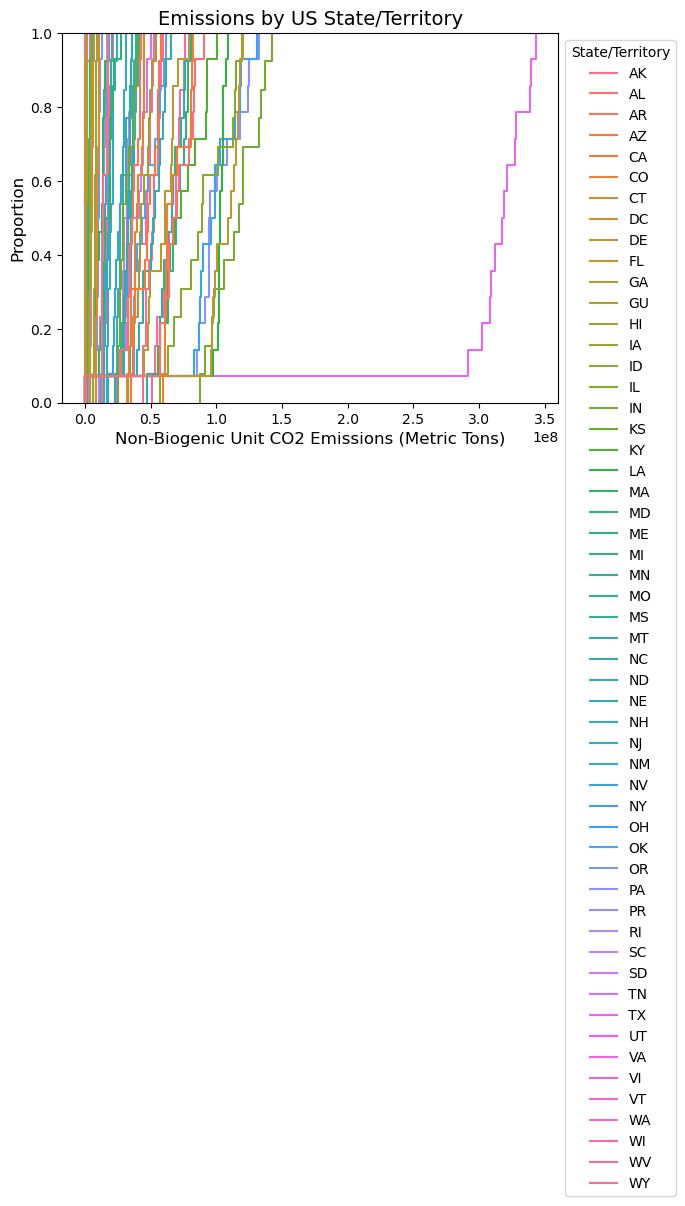

In [17]:
# ECDF of CO2 emissions (no log transformation ) metric tons
ax = sns.ecdfplot(data=grouped_emissions, x="Non-Biogenic Unit CO2 Emissions", hue = "State/Territory")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title("Emissions by US State/Territory", fontsize=14)
ax.set_xlabel("Non-Biogenic Unit CO2 Emissions (Metric Tons)", fontsize=12)
ax.set_ylabel("Proportion", fontsize=12)

Text(0.5, 1.0, 'Emissions by US State/Territory')

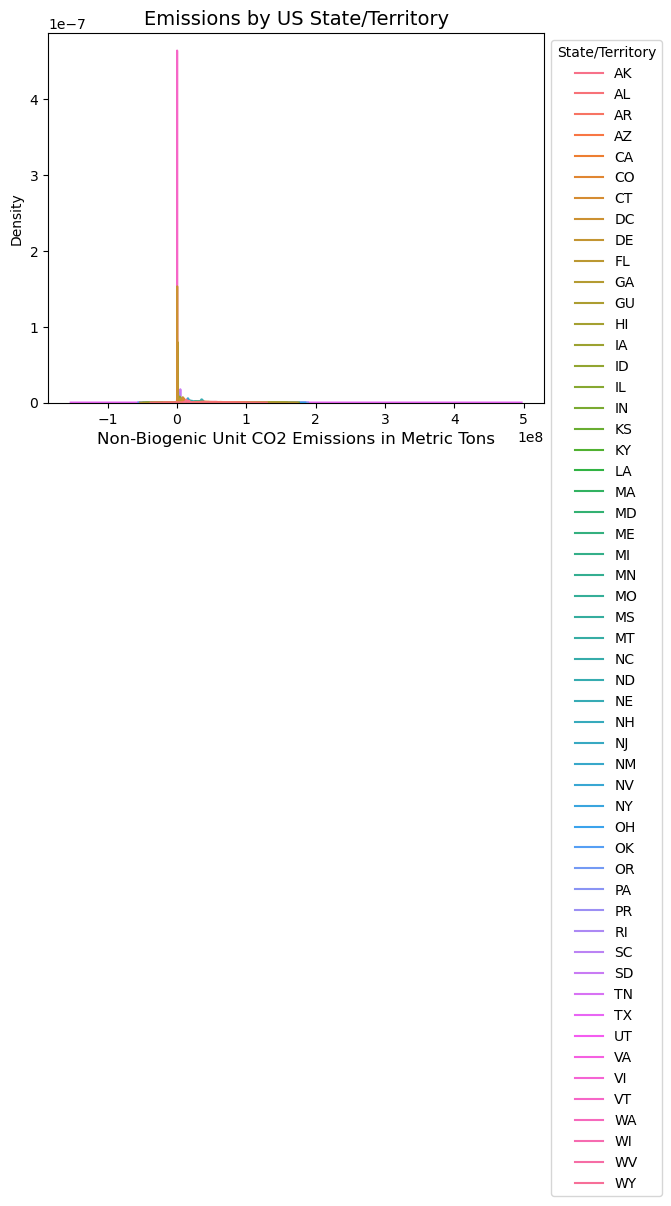

In [18]:
# KDE of CO2 emissions (no log transformation ) metric tons
ax = sns.kdeplot(data=grouped_emissions, x="Non-Biogenic Unit CO2 Emissions", hue="State/Territory")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel("Non-Biogenic Unit CO2 Emissions in Metric Tons", fontsize=12)
ax.set_title("Emissions by US State/Territory", fontsize=14)

## Graphing the Log of the Emissions Data: ECDF and KDE

Text(0, 0.5, 'Proportion')

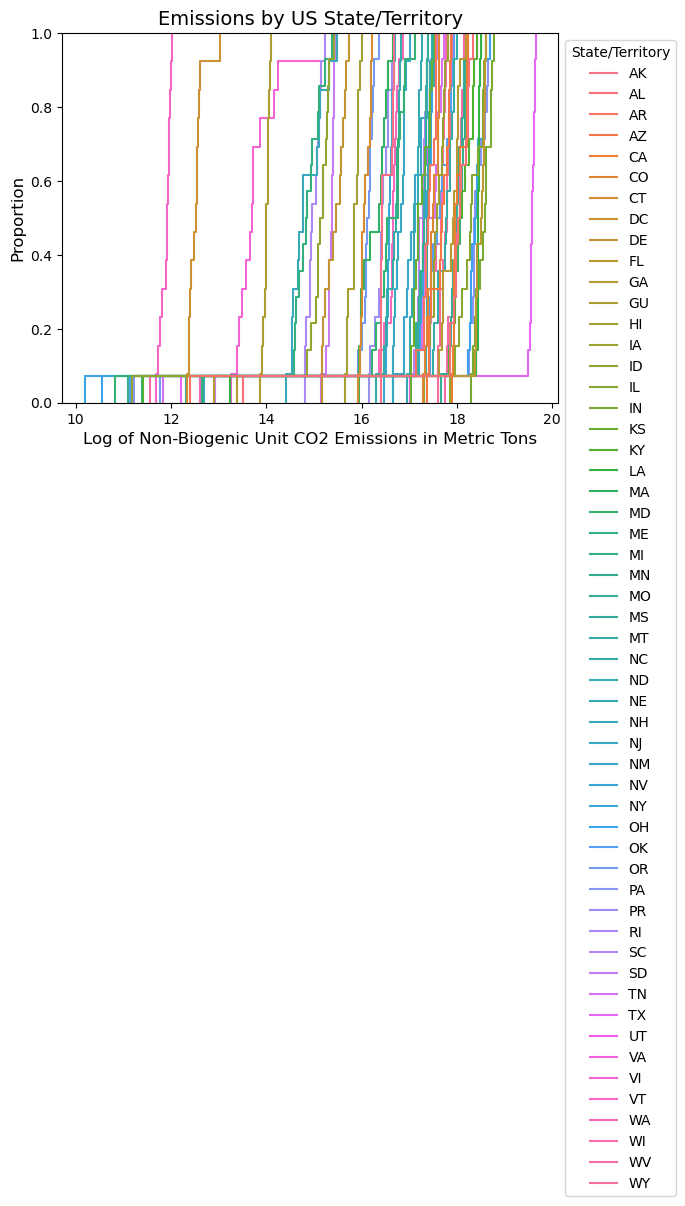

In [19]:
# ECDF of logged CO2 emissions metric tons

ax = sns.ecdfplot(data=grouped_emissions, x="UnitE_Log", hue = "State/Territory")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title("Emissions by US State/Territory", fontsize=14)
ax.set_xlabel("Log of Non-Biogenic Unit CO2 Emissions in Metric Tons", fontsize=12)
ax.set_ylabel("Proportion", fontsize=12)

Text(0.5, 1.0, 'Emissions by US State/Territory')

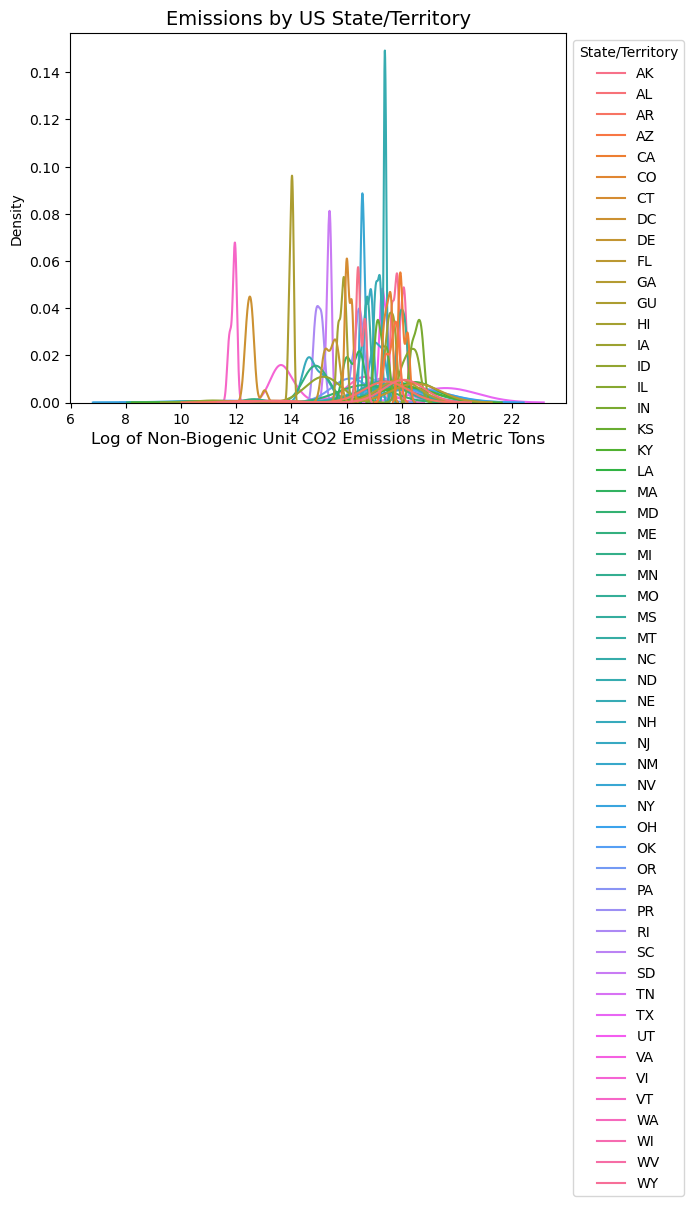

In [20]:
# KDE of logged CO2 emissions metric tons

ax = sns.kdeplot(data=grouped_emissions, x="UnitE_Log", hue="State/Territory")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel("Log of Non-Biogenic Unit CO2 Emissions in Metric Tons", fontsize=12)
ax.set_title("Emissions by US State/Territory", fontsize=14)

## Finding Emittors Per Area

In [21]:
# Merge dataframes
merged = pd.merge(grouped_emissions, area, on='State/Territory')
merged.head()

,State/Territory,Year,Non-Biogenic Unit CO2 Emissions,UnitE_Log,SqMi,SqMi_Log
0,AK,2011,1.748238e+07,16.676704,665384,13.40812
1,AK,2012,1.760305e+07,16.683583,665384,13.40812
2,AK,2013,1.727435e+07,16.664733,665384,13.40812
3,AK,2014,1.672759e+07,16.632570,665384,13.40812
4,AK,2015,1.719359e+07,16.660047,665384,13.40812


In [22]:
merged['Ratio'] = merged['Non-Biogenic Unit CO2 Emissions']/merged['SqMi']
merged.head()

,State/Territory,Year,Non-Biogenic Unit CO2 Emissions,UnitE_Log,SqMi,SqMi_Log,Ratio
0,AK,2011,1.748238e+07,16.676704,665384,13.40812,26.274125
1,AK,2012,1.760305e+07,16.683583,665384,13.40812,26.455470
2,AK,2013,1.727435e+07,16.664733,665384,13.40812,25.961479
3,AK,2014,1.672759e+07,16.632570,665384,13.40812,25.139752
4,AK,2015,1.719359e+07,16.660047,665384,13.40812,25.840102


Text(0, 0.5, 'Proportion')

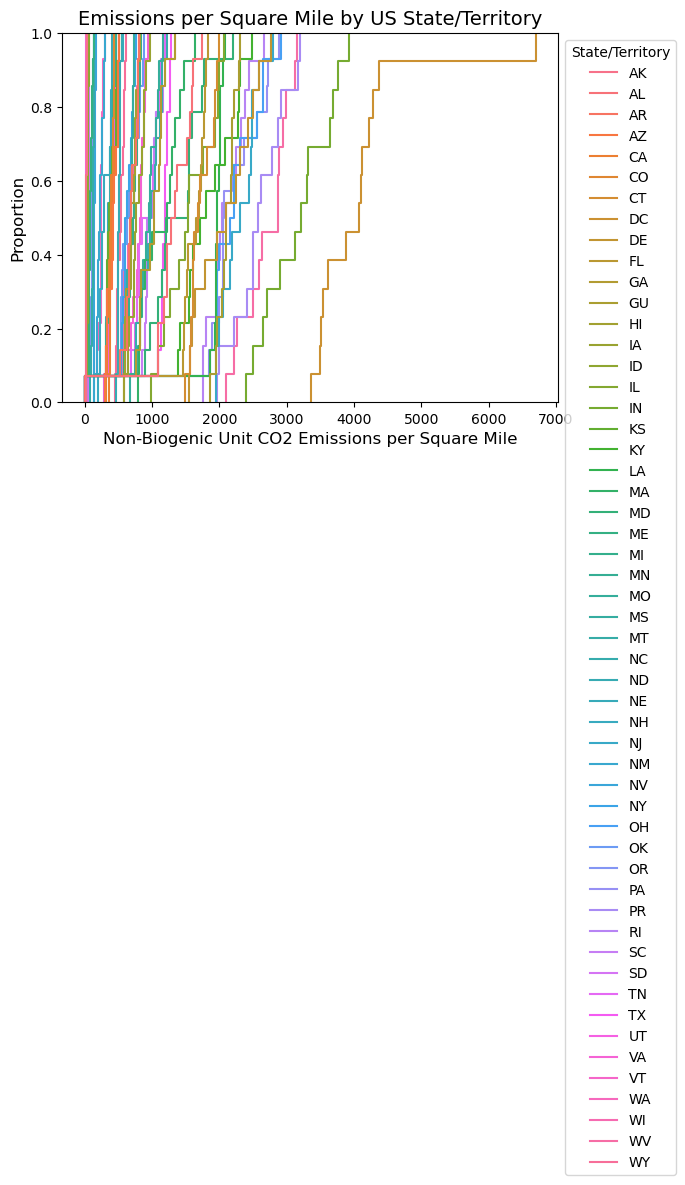

In [23]:
# ECDF of ratio

ax = sns.ecdfplot(data=merged, x="Ratio", hue = "State/Territory")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title("Emissions per Square Mile by US State/Territory", fontsize=14)
ax.set_xlabel("Non-Biogenic Unit CO2 Emissions per Square Mile", fontsize=12)
ax.set_ylabel("Proportion", fontsize=12)

Text(0.5, 1.0, 'Emissions per Square Mile by US State/Territory')

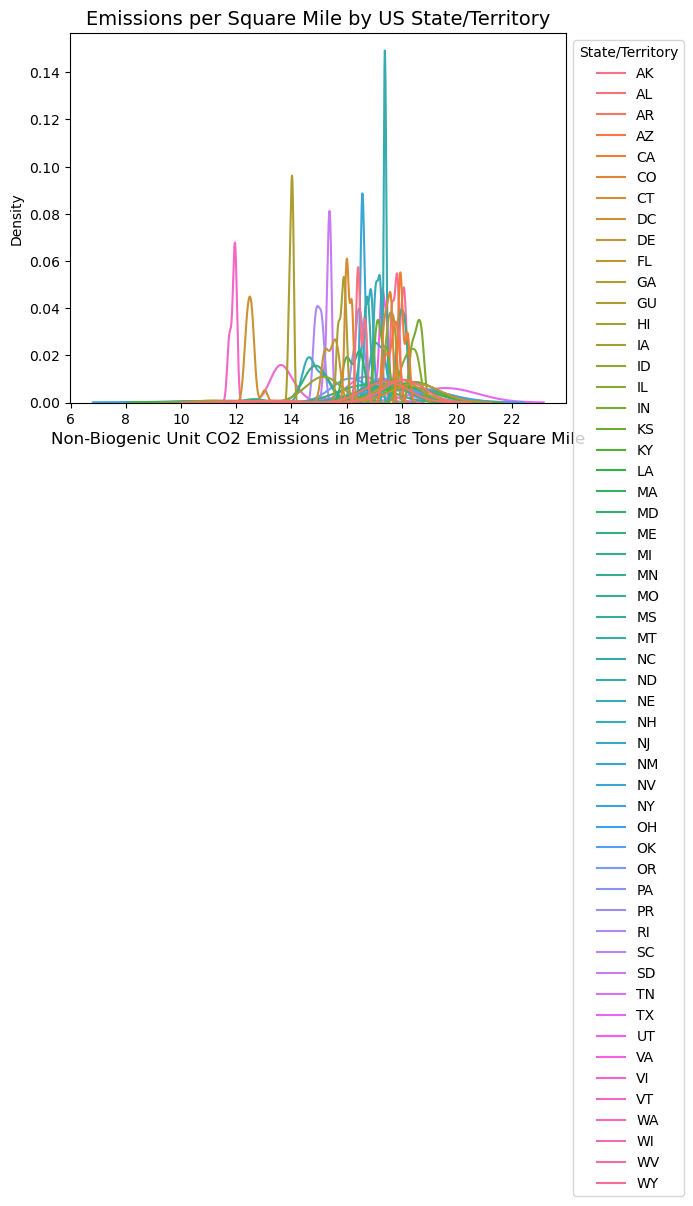

In [24]:
# KDE of ratio

ax = sns.kdeplot(data=grouped_emissions, x="UnitE_Log", hue="State/Territory")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel("Non-Biogenic Unit CO2 Emissions in Metric Tons per Square Mile", fontsize=12)
ax.set_title("Emissions per Square Mile by US State/Territory", fontsize=14)

## Identifying the Greatest Emitters 

In [25]:
# What is the average emission ratio over the years?
merged_avg = merged.groupby('State/Territory').agg({'Ratio':'mean'}).sort_values(by='Ratio')

# What are the 5 first (lowest) and 5 last (highest) emitters per area?
merged_extreme =  merged_avg.tail()
merged_extreme

,Ratio
State/Territory,
NJ,2298.062312
PR,2590.739225
WV,2700.915952
IN,3162.917299
DC,4097.925905


In [26]:
# Only selecting the 5 highest emmitors from the merged df
states_to_select = ['NJ', 'PR', 'WV', 'IN', 'DC']
filter_mask = merged['State/Territory'].isin(states_to_select)
selected_states = merged[filter_mask]
selected_states

,State/Territory,Year,Non-Biogenic Unit CO2 Emissions,UnitE_Log,SqMi,SqMi_Log,Ratio
93,DC,2011,455688.80,13.029565,68,4.219508,6701.305882
94,DC,2012,280235.80,12.543387,68,4.219508,4121.114706
95,DC,2013,263970.40,12.483592,68,4.219508,3881.917647
96,DC,2014,287477.80,12.568901,68,4.219508,4227.614706
97,DC,2015,245449.80,12.410848,68,4.219508,3609.555882
...,...,...,...,...,...,...,...
695,WV,2019,60571699.50,17.919338,24230,10.095347,2499.863785
696,WV,2020,53564193.80,17.796391,24230,10.095347,2210.655955
697,WV,2021,62643714.10,17.952974,24230,10.095347,2585.378213
698,WV,2022,54791548.21,17.819047,24230,10.095347,2261.310285


Text(0, 0.5, 'Proportion')

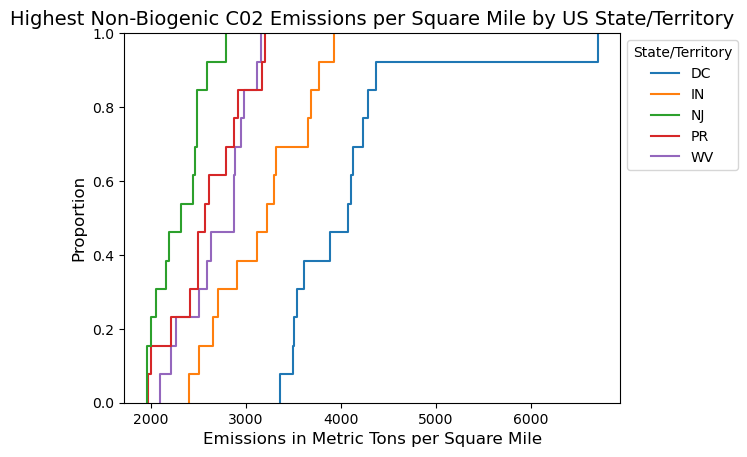

In [27]:
# ECDF of high ratios

ax = sns.ecdfplot(data=selected_states, x="Ratio", hue = "State/Territory")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title("Highest Non-Biogenic C02 Emissions per Square Mile by US State/Territory", fontsize=14)
ax.set_xlabel("Emissions in Metric Tons per Square Mile", fontsize=12)
ax.set_ylabel("Proportion", fontsize=12)

Text(0.5, 1.0, 'Highest Non-Biogenic C02 Emissions per Square Mile by US State/Territory')

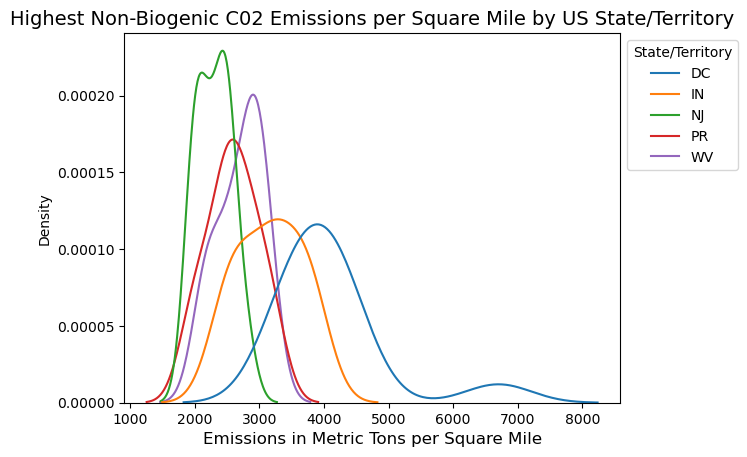

In [28]:
# KDE of highest ratios

ax = sns.kdeplot(data=selected_states, x="Ratio", hue = "State/Territory")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel("Emissions in Metric Tons per Square Mile", fontsize=12)
ax.set_title("Highest Non-Biogenic C02 Emissions per Square Mile by US State/Territory", fontsize=14)

## Exploring Population Density

In [13]:
"""
Source: https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_population_density#:~:text=Table_title:%20States%20and%20territories%20by%20population%20density,%7C%20Density:%201%2C060%20%7C%20:%20409%20%7C
"""
# Loading data on population density
density = pd.read_csv('density.csv',skiprows=2)
density.head()

,/mi2,/km2,mi2
0,District of Columbia,"11,131","4,297"
1,New Jersey,"1,263",488
2,Rhode Island,"1,060",409
3,Puerto Rico,936,361
4,Massachusetts,898,347


In [ ]:
# Cleaning up the data
replace_map = {'/mi2': 'State/Territory',
               '/km2': 'per_km_2',
               'mi2': 'per_mi_2'}

density = density.rename(columns=replace_map)  
density 

,State/Territory,per_km_2,per_mi_2
0,District of Columbia,"11,131","4,297"
1,New Jersey,"1,263",488
2,Rhode Island,"1,060",409
3,Puerto Rico,936,361
4,Massachusetts,898,347
5,Guam[4],824,319
6,Connecticut,747,288
7,U.S. Virgin Islands[4],737,284
8,Maryland,637,246
9,American Samoa[4],578,222


### NJ = #2 most densely populated
### PR = #4 most densely populated
### WV = #34 most densely populated --> outsize impact?
### IN = #23 most densely populated --> outsize impact?
### DC = #1 most densely populated

## Questions

How are you fitting your model to the phenomenon to get realistic properties of the data?
- We had to aggregate all the cities together to get one row per State and Year
- We picked Non-Biogenic CO2 emissions to focus on because it is the type of emission that is a result of non-renewable carbon sources such as Coal, Oil, Natural gas, and Petroleum products. These are human-caused CO2 emissions rather than natural processes. These carbon dioxide sources are directly addressable by humans and are therefore intriguing from a media and communications perspective. 
- We wanted to get a sense of emissions per area - some states may have larger emissions by virtue of being a larger state, and it's not good practice to assign that state a descriptor of "large emittor" without taking this into account. This gave us a realistic picture of the data.
 
What challenges did you have to overcome? 
- The emissions were large and constituted a large range - so taking a log helped standardize the data and make it easier to visualize. The overall quality of the data was good in part due to pre-cleaning the data ahead of visualizations. 
- The area was also large with a large range; taking a log solved the same problems.
- Should we have normalzied for population data?

## Bootstrapping

In [29]:
def stat(x):
    stat = np.mean(x)
    return stat

In [35]:
def simulate_by_state(var, df, fcn, S=1000, plot=True):
    results = []

    for state in df['State/Territory'].dropna().unique():
        x = df.loc[df['State/Territory'] == state, var]

        estimates = []
        for s in range(S):
            x_s = x.sample(frac=1.0, replace=True)
            estimates.append(fcn(x_s))  

        estimates = np.array(estimates) 

       
        results.extend([{"State/Territory": state, "Ratio": val} for val in estimates])

    df_boot = pd.DataFrame(results)

    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        # --- KDE Plot (axes[0]) ---
        # The seaborn call creates the plot and the legend data
        sns.kdeplot(data=df_boot, x="Ratio", hue="State/Territory", ax=axes[0])
        axes[0].set_title("KDE of Bootstrapped Estimates")

        # Access the legend object and set its location (e.g., inside top-right)
        legend0 = axes[0].get_legend()
        if legend0:
            legend0.set_bbox_to_anchor((1.0, 1.0))
            legend0.set_loc('upper right')
            legend0.set_title('State/Territory')
        
        # --- ECDF Plot (axes[1]) ---
        sns.ecdfplot(data=df_boot, x="Ratio", hue="State/Territory", ax=axes[1])
        axes[1].set_title("ECDF of Bootstrapped Estimates")

        # Access the legend object and set its location (e.g., outside top-right)
        legend1 = axes[1].get_legend()
        if legend1:
            legend1.set_bbox_to_anchor((1.05, 1.0)) # Move slightly outside (1.05)
            legend1.set_loc('upper left')
            legend1.set_title('State/Territory')

        # Use plt.tight_layout() to prevent the outside legend from being cut off
        plt.tight_layout()

        plt.show()

    return df_boot

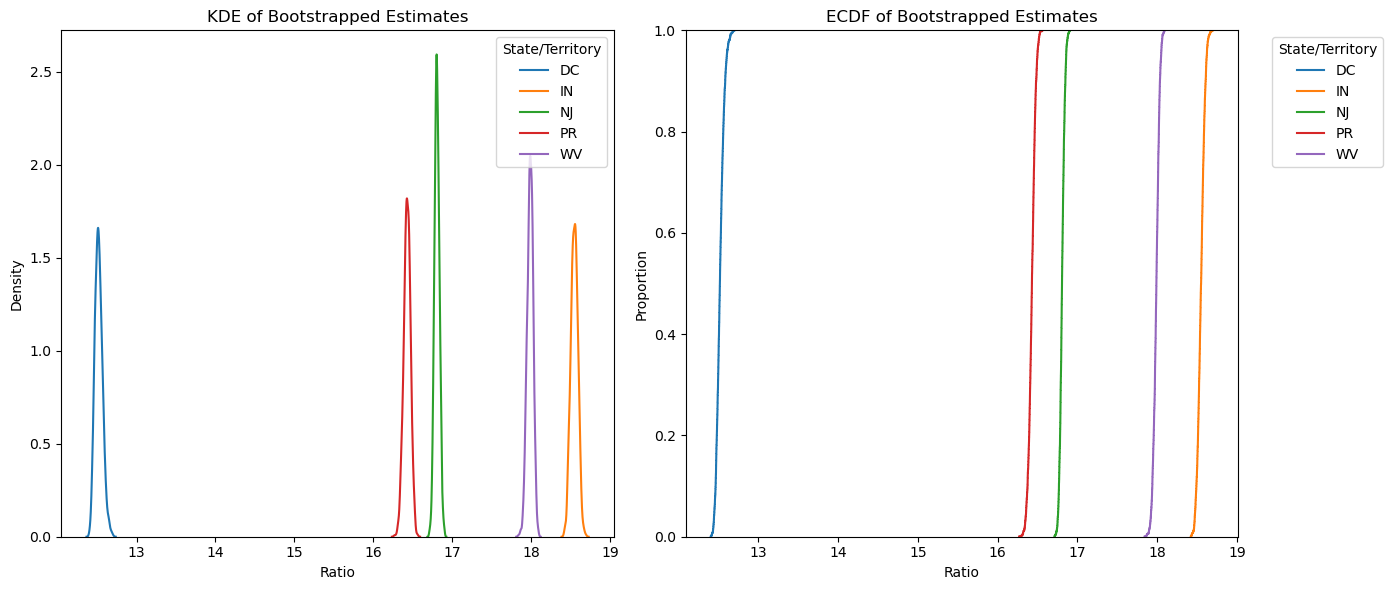

,State/Territory,Ratio
0,DC,12.517373
1,DC,12.473419
2,DC,12.490510
3,DC,12.507414
4,DC,12.559546
...,...,...
4995,WV,18.003994
4996,WV,18.004325
4997,WV,17.960312
4998,WV,17.949486


In [36]:
var = 'UnitE_Log'
simulate_by_state(var, selected_states, stat)

## Bootstrapped ECDF/KDE for the overall log transformed bootstrapped (did not use this in #5 question)

In [ ]:
def simulate(var, df, fcn, S=1000, plot=True): # S variable is the amount of times you are bootstrapping
    ''' Bootstrap simulation code. '''    
    x = df[var]

    estimates = []
    for s in range(S): # drawing 100 estimates from the mean 
        # Draw a new sample, with replacement:
        x_s = x.sample(frac=1.0,replace=True) #frac --> 100% of sample (1.0)
            # this ^^ is basically saying to make a new sample with the same number of rows 
            # as the original sample size but replace the values when you draw one
        # Compute statistic:
        stat_s = fcn(x_s)
        # Append estimate:
        estimates.append(stat_s)
    estimates = np.array(estimates) # Convert estimates list to numpy array

    ## or in one line, 
    #estimates = [fcn(x.sample(frac=1.0,replace=True)) for s in range(S)]

    if plot:
        fig, axes = plt.subplots(1, 3, figsize=(16, 4))  # 1 row, 2 columns
        sns.kdeplot(x, ax = axes[0]).set(title='KDE of Underlying Data')
        sns.kdeplot(estimates, ax = axes[1]).set(title='KDE of Computed Statistics')
        axes[1].axvline(x=fcn(x), color='orange', linestyle='--')
        sns.ecdfplot(estimates, ax = axes[2]).set(title='ECDF of Computed Statistics')
        axes[2].axvline(x=fcn(x), color='orange', linestyle='--')
        plt.show()
        print(f'Variance of estimates is: {np.var(estimates)}')
        
    return estimates


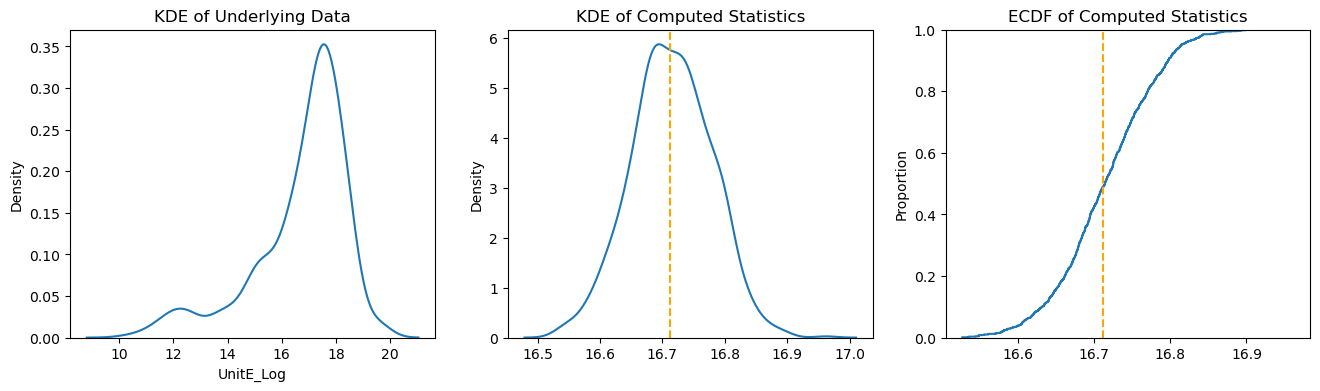

Variance of estimates is: 0.004145127949753474


array([16.6285186 , 16.72963902, 16.72884758, 16.72325082, 16.7107392 ,
       16.74328899, 16.73193446, 16.66008741, 16.61276856, 16.64637189,
       16.66965136, 16.70662402, 16.57964243, 16.84364625, 16.66211365,
       16.71428346, 16.69287377, 16.72521399, 16.68915612, 16.81589018,
       16.67903627, 16.70531211, 16.6211192 , 16.77954155, 16.72971214,
       16.76758488, 16.73362922, 16.79434345, 16.60883841, 16.70425611,
       16.79330631, 16.7188267 , 16.79190963, 16.76821032, 16.6347955 ,
       16.62173503, 16.74339185, 16.71266948, 16.71286208, 16.63019666,
       16.62342993, 16.76747263, 16.78601984, 16.74013428, 16.78273859,
       16.64170457, 16.6947752 , 16.6598917 , 16.7310545 , 16.68241542,
       16.62079323, 16.7976857 , 16.7707568 , 16.66302618, 16.64512119,
       16.71520659, 16.7357316 , 16.72789426, 16.79311112, 16.72031939,
       16.64842544, 16.78183441, 16.72565506, 16.78152104, 16.60425302,
       16.6810825 , 16.75336751, 16.79836611, 16.76796752, 16.70

In [ ]:
var = 'UnitE_Log'
simulate(var, selected_states, stat)